# Untitled Supermarked Project
## Queing Simulator

### Importing Libraries

In [112]:
# DataFrames
import pandas as pd
# Visualizations
import matplotlib.pyplot as plt
# Statistics
from scipy import stats 
# Array and Array Math
import numpy as np

### Homebrew Functions

In [106]:
# Random generates an Entry-Process
def entry_process(packages, variable, parameters):
    # Set up Collector for results
    results       = pd.DataFrame([])
    # Generates random numbers between Customers
    results["time"]  = variable(** parameters, size = packages)
    # Sum up to determine entry time of each customer
    results["entry"] = results.time.cumsum()
    # Return result
    return results["entry"]

In [107]:
# Random-generates the the service-process and the resulting exit-process
def service_process(entries, variable, parameters):
    # Set up Station
    station = 0
    # Set up Collectors for Results
    results_service = ([])
    results_exit    = ([])
    # Cycle through Customers of the Entry-Process
    for idx in entries:
        # Add Time when Customer is being serviced
        results_service.append(max(idx,station))
        # Generate time when Customer is done
        done = float(max(idx,station) + variable(** parameters, size = 1))
        # Add Time when Customer is done
        results_exit.append(done)
        # Update Station
        station = done
    # Return results
    return results_service, results_exit

### Test Run

In [110]:
n_customers                 = 100
entry_variable              = stats.expon.rvs
entry_variable_parameters   = {"loc" : 0, "scale" : 1/2, "random_state" : None}
service_variable            = stats.expon.rvs
service_variable_parameters =  {"loc" : 0, "scale" : 1/2, "random_state" : None}

In [111]:
overview = pd.DataFrame([])
overview["entry"]                     = entry_process(n_customers,
                                                      entry_variable,
                                                      entry_variable_parameters)
overview["service"], overview["exit"] = service_process(overview["entry"],
                                                        service_variable,
                                                        service_variable_parameters)
overview

,entry,service,exit
0,0.422201,0.422201,0.779548
1,0.429819,0.779548,1.563712
2,0.749083,1.563712,2.048253
3,1.378427,2.048253,2.247845
4,2.893602,2.893602,2.997008
...,...,...,...
95,44.474219,48.874009,49.038599
96,44.680379,49.038599,49.204344
97,44.991241,49.204344,49.764217
98,45.224497,49.764217,51.244050


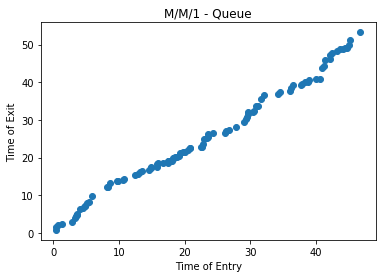

In [120]:
plt.title("M/M/1 - Queue")
plt.scatter(x = overview.entry, y = overview.exit)
plt.xlabel("Time of Entry")
plt.ylabel("Time of Exit")
plt.show()

## Future Works
- Multiple Stations<br>
- Multiple Stations, non Stationary<br>
- Multiple Stations, non Stationar, via Shiftplan<br>
- Non Stationary Entry-Process<br>
- Consider Object-Oriented approach<br>